# Chapter 4: Building Models with Distance Metrics and Nearest Neighbors

This notebook provides practical "recipes" for using k-nearest neighbors (KNN) and distance metrics for clustering, classification, and regression tasks in scikit-learn. Each recipe includes explanations, code examples, visualizations, best practices, and common pitfalls. We'll cover implementation, tuning, and evaluation of KNN models.

## Understanding k-nearest neighbors (KNN)

### Getting ready
KNN is a simple yet powerful classification algorithm that:
- Makes predictions based on the "k" closest training examples
- Is non-parametric (no assumptions about data distribution)
- Can be used for both classification and regression

In [1]:
# Load libraries
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2024
)

### How to do it
To implement a basic KNN model using scikit-learn, follow these steps. As you can see, this follows the same design paradigm as the other models we've seen in this book so far.

In [2]:
# Load libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create and train a basic KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9333333333333333


### How it works
The KNN algorithm works by:
1. Storing all training examples
2. For each new point:
   - Calculating distances to all training examples
   - Finding the k nearest neighbors
   - Taking a majority vote (for classification) or average (for regression)

## Distance Metrics Overview

### Getting ready
We’ll create two new datasets for illustrating the differences between distance metrics using scikit-learn’s built-in make_circles() function.

In [3]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Create two synthetic datasets that highlight metric differences
n_samples = 300

# Circular dataset with high noise (Euclidean distance should work better)
X_circles, y_circles = make_circles(n_samples=n_samples, noise=0.3, factor=0.3)
X_circles_train, X_circles_test, y_circles_train, y_circles_test = train_test_split(
    X_circles, y_circles, test_size=0.2, random_state=2024
)

# Checkerboard pattern dataset (Manhattan distance should work better)
x = np.linspace(0, 4, int(np.sqrt(n_samples)))
y = np.linspace(0, 4, int(np.sqrt(n_samples)))
xx, yy = np.meshgrid(x, y)
X_moons = np.column_stack((xx.ravel(), yy.ravel()))
y_moons = np.mod(np.floor(xx.ravel()) + np.floor(yy.ravel()), 2)
X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
    X_moons, y_moons, test_size=0.2, random_state=2024
)

### How to do it

To compare various distance metrics, we’ll cycle through each one and build two KNN classifiers with it on our datasets, then visualize the dataset along with the performance metric, accuracy.

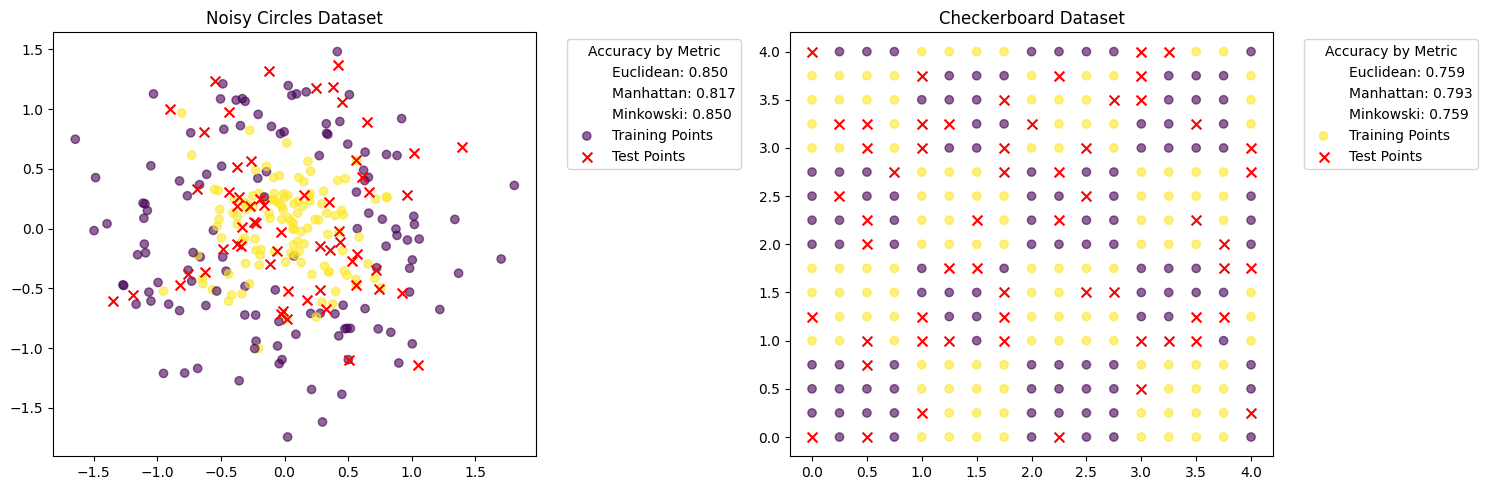

In [4]:
# Compare different distance metrics on both datasets
metrics = ['euclidean', 'manhattan', 'minkowski']
results = {'circles': {}, 'moons': {}}

for metric in metrics:
    # Test on "circles" dataset
    knn_circles = KNeighborsClassifier(n_neighbors=3, metric=metric)
    knn_circles.fit(X_circles_train, y_circles_train)
    y_pred_circles = knn_circles.predict(X_circles_test)
    results['circles'][metric] = accuracy_score(y_circles_test, y_pred_circles)
    
    # Test on "moons" dataset
    knn_moons = KNeighborsClassifier(n_neighbors=3, metric=metric)
    knn_moons.fit(X_moons_train, y_moons_train)
    y_pred_moons = knn_moons.predict(X_moons_test)
    results['moons'][metric] = accuracy_score(y_moons_test, y_pred_moons)

# Set up plot specs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot circles dataset
scatter1_train = ax1.scatter(X_circles_train[:, 0], X_circles_train[:, 1], c=y_circles_train, cmap='viridis', alpha=0.6, label='Training Points')
scatter1_test = ax1.scatter(X_circles_test[:, 0], X_circles_test[:, 1], color='red', marker='x', s=50, label='Test Points')
ax1.set_title('Noisy Circles Dataset')

# Create dummy lines for legend
lines1 = [plt.Line2D([0], [0], color='white') for _ in metrics]
legend_text1 = [
    f"Euclidean: {results['circles']['euclidean']:.3f}",
    f"Manhattan: {results['circles']['manhattan']:.3f}",
    f"Minkowski: {results['circles']['minkowski']:.3f}"
]
ax1.legend(lines1 + [scatter1_train, scatter1_test], legend_text1 + ['Training Points', 'Test Points'], 
          title='Accuracy by Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot moons dataset
scatter2_train = ax2.scatter(X_moons_train[:, 0], X_moons_train[:, 1], c=y_moons_train, cmap='viridis', alpha=0.6, label='Training Points')
scatter2_test = ax2.scatter(X_moons_test[:, 0], X_moons_test[:, 1], color='red', marker='x', s=50, label='Test Points')
ax2.set_title('Checkerboard Dataset')

# Create dummy lines for legend
lines2 = [plt.Line2D([0], [0], color='white') for _ in metrics]
legend_text2 = [
    f"Euclidean: {results['moons']['euclidean']:.3f}",
    f"Manhattan: {results['moons']['manhattan']:.3f}",
    f"Minkowski: {results['moons']['minkowski']:.3f}"
]
ax2.legend(lines2 + [scatter2_train, scatter2_test], legend_text2 + ['Training Points', 'Test Points'],
          title='Accuracy by Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Hyperparameter Tuning in KNN

Hyperparameter tuning is a critical step in optimizing the performance of machine learning models, including KNN

### Getting ready

We will use our original dataset, the Iris dataset, and tune the number of neighbors, whether or not to weight our training data by distance from our test data, and the choice of distance metric.

### How to do it

To perform hyperparameter tuning for KNN, we will use the grid search approach. Grid search is a hyperparameter technique that tests an exhaustive number of combinations of model hyperparameters – all combinations are tested with the resulting combination returned to us as the optimal set. Additionally, cross-validation is used to add an element of randomization that aids in making sure our model is robust when used in the real world.

In [5]:
# Load libraries
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Create KNN classifier
knn = KNeighborsClassifier()

# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan']
}

# Create grid search
grid_search = GridSearchCV(
    knn, param_grid, cv=5, scoring='accuracy'
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Best cross-validation score: 0.9916666666666668


## Evaluating KNN Performance

Evaluating the performance of KNN models is essential for understanding how well the model makes predictions and where it may need improvement. This section will cover various techniques for assessing KNN performance, including confusion matrices, precision, recall, and F1 scores. 

### Getting ready
Again, we will use our toy dataset from before, the Iris dataset, and import a few new functions to help us evaluate our model. We'll evaluate our model using:
- Cross-validation scores
- Learning curves
- Confusion matrix

In [6]:
# Load libraries
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

### How to do it...

To evaluate the performance of your KNN model, we’ll use the three different approaches mentioned above. If you refer to the visualizations located in the output of this code block, you'll get some insights into the performance of your model. For example, the learning curves show that the model doesn't improve much after ~50 training examples, and the confusion matrix shows that the model is having trouble distinguishing between the first and second classes.

The classification report provides a detailed breakdown of the model's performance, including precision, recall, and F1 scores for each class. The fact that the setosa class has a high precision, recall, and F1 score indicates that the model is doing well at predicting this class, but since it's predicting with 100 percent accuracy it's probably an indication of overfitting.

(NOTE: The "accuracy" measure is shown in the table three times, but it's the same value for each class since accuracy is an overall measure of the model's performance across classes.)


Cross-validation scores: [0.95833333 1.         1.         1.         1.        ]
Mean CV score: 0.9916666666666668
Standard deviation: 0.016666666666666653


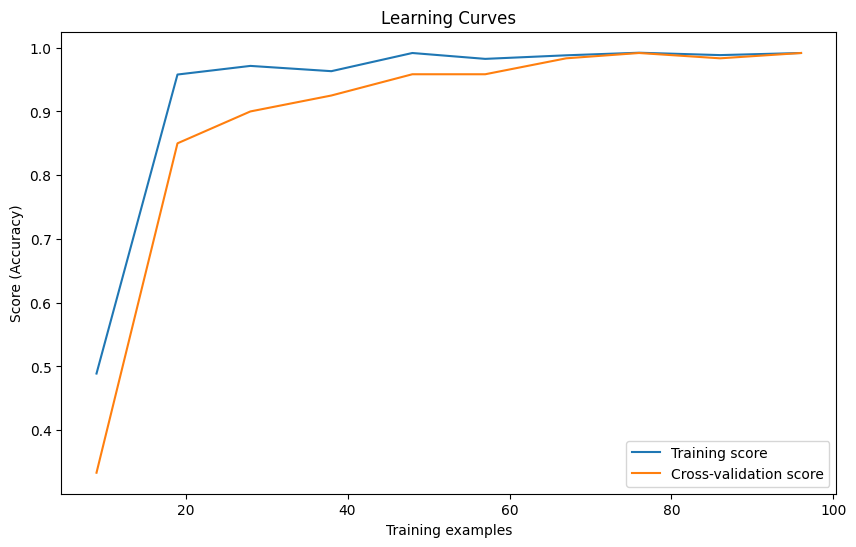

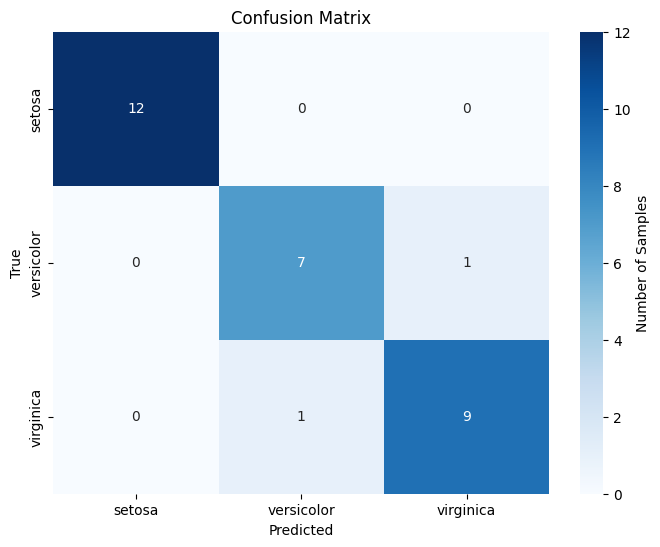


Classification Report:


,precision,recall,f1-score,support
setosa,1.000,1.000,1.000,12
versicolor,0.875,0.875,0.875,8
virginica,0.900,0.900,0.900,10
accuracy,0.933,0.933,0.933,1
macro avg,0.925,0.925,0.925,30
weighted avg,0.933,0.933,0.933,30


In [7]:
# Get cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5
)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score (Accuracy)')
plt.legend(loc='best')
plt.title('Learning Curves')
plt.show()

# Make predictions on test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Get class names from iris dataset
class_names = iris.target_names

# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Number of Samples'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Get classification report as a dict
report_dict = classification_report(y_test, y_pred, 
                                  target_names=class_names,
                                  output_dict=True)

# Create a DataFrame for better visualization
report_df = pd.DataFrame(report_dict).transpose()

# Style the DataFrame
styled_df = (report_df
    .style
    .background_gradient(cmap='Blues', subset=['precision', 'recall', 'f1-score'])
    .format({
        'precision': '{:.3f}',
        'recall': '{:.3f}',
        'f1-score': '{:.3f}',
        'support': '{:.0f}'
    })
)

print("\nClassification Report:")
display(styled_df)

## Practical Exercises with KNN Models

### Exercise 1: Building a KNN Classifier
Implement a KNN classifier for a binary classification problem

In [8]:
# Load libraries
YOUR CODE HERE

# Load the Dataset
YOUR CODE HERE

# Preprocess the Data
YOUR CODE HERE

# Create and Train the KNN Classifier
YOUR CODE HERE

# Make Predictions
YOUR CODE HERE

# Evaluate Performance
YOUR CODE HERE


SyntaxError: invalid syntax (200144518.py, line 2)

### Exercise 2: Tuning Hyperparameters with Grid Search
Compare the performance of different KNN models using grid search


In [ ]:
# Load libraries
YOUR CODE HERE

# Load a different dataset
YOUR CODE HERE

# Preprocess the data
YOUR CODE HERE

# Set up grid search: 
YOUR CODE HERE

# Fit grid search
YOUR CODE HERE
# Evaluate best model
YOUR CODE HERE


### Exercise 3 Evaluating a KNN Classifier
Evaluate the performance of a KNN classifier using the techniques we've covered in this chapter

In [ ]:
# Load libraries
YOUR CODE HERE

# Load the Dataset
YOUR CODE HERE

# Preprocess the Data
YOUR CODE HERE

# Create and Train the KNN Classifier
YOUR CODE HERE

# Make Predictions
YOUR CODE HERE
# Evaluate Performance
YOUR CODE HERE